<a href="https://colab.research.google.com/github/Greg-Vincent0711/GAVConsulting/blob/main/03_MultiClass_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
import torch.nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

def setCorrectDevice(device_to_set: torch.Tensor):
  return device_to_set.to(device)

def calculateAccuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

# multi class data creation
# hyperparameters for data creation
CLASSES = 4
FEATURES = 2
RANDOM_SEED = 42

# creating multi class data
# y_blob is the arr of labels for all samples
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=FEATURES,
                            centers=CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Scikit learn uses Numpy, so to work with Pytorch data has to be
# turned into tensors...but does NOT automatically put them on the GPU
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# split data into train/test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# visualizing data
plt.figure(figsize=(10,7))
# since plt uses the numpy which uses the cpu, convert to gpu afterwards
# plt.scatter(X_blob[:, 0], X_blob[:, 1],c=y_blob, cmap=plt.cm.RdYlBu)

X_blob_train = setCorrectDevice(X_blob_train)
X_blob_test = setCorrectDevice(X_blob_test)
y_blob_train = setCorrectDevice(y_blob_train)
y_blob_test = setCorrectDevice(y_blob_test)


<Figure size 1000x700 with 0 Axes>

In [69]:
import torch
import torch.nn as nn
# Building a multi-class classification model


class Multi_Classifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_0 = Multi_Classifier(input_features=2,output_features=CLASSES).to(device)
model_0

Multi_Classifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [70]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

model_0.eval()
with torch.inference_mode():
  # looking at some initial predictions from the model
  test_blob_logits = model_0(X_blob_test)

  test_blob_probs = torch.softmax(test_blob_logits,dim=1)
# softmax also makes it so that all probabilites add to 1
test_blob_probs[0], torch.sum(test_blob_probs[0])

'''
say a sample is tensor([0.2932, 0.1851, 0.3205, 0.2012]
since each # is a probability, the argmax is which is most likely
for a given value

entire pipeline:
  -> forward pass to make logits
  -> call softmax to make probabilities
  -> call argmax to make predictions
  -> compare predictions to labels
'''

'\nsay a sample is tensor([0.2932, 0.1851, 0.3205, 0.2012]\nsince each # is a probability, the argmax is which is most likely\nfor a given value\n\nentire pipeline:\n  -> forward pass to make logits\n  -> call softmax to make probabilities\n  -> call argmax to make predictions\n  -> compare predictions to labels\n'

In [71]:
# before training
torch.argmax(test_blob_probs,dim=1)[:5], y_blob_test[:5]

(tensor([1, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

In [72]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# training and testing the model
epochs = 100
for epoch in range(epochs):
  model_0.train()
  training_logits = model_0(X_blob_train)
  training_preds = torch.softmax(training_logits, dim=1).argmax(dim=1)
  loss_amount = loss(training_logits, y_blob_train)
  # accuracy fn only works with predictions
  train_acc = calculateAccuracy(y_true=y_blob_train,
                                y_pred=training_preds)
  optimizer.zero_grad()
  loss_amount.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss(test_logits, y_blob_test)
    test_acc = calculateAccuracy(y_true=y_blob_test, y_pred=test_preds)
  if epoch % 10 == 0:
    print(f'Epoch {epoch} TRAIN: loss: {loss_amount:.3f}, acc: {train_acc:.2f}% | TEST: loss {test_loss:.3f}, acc: {test_acc:.2f}%')

Epoch 0 TRAIN: loss: 1.159, acc: 40.38% | TEST: loss 1.076, acc: 48.00%
Epoch 10 TRAIN: loss: 0.645, acc: 96.75% | TEST: loss 0.661, acc: 97.50%
Epoch 20 TRAIN: loss: 0.425, acc: 98.50% | TEST: loss 0.431, acc: 100.00%
Epoch 30 TRAIN: loss: 0.253, acc: 99.12% | TEST: loss 0.245, acc: 99.50%
Epoch 40 TRAIN: loss: 0.112, acc: 99.25% | TEST: loss 0.102, acc: 99.50%
Epoch 50 TRAIN: loss: 0.066, acc: 99.25% | TEST: loss 0.058, acc: 99.50%
Epoch 60 TRAIN: loss: 0.051, acc: 99.25% | TEST: loss 0.043, acc: 99.50%
Epoch 70 TRAIN: loss: 0.043, acc: 99.25% | TEST: loss 0.035, acc: 99.50%
Epoch 80 TRAIN: loss: 0.038, acc: 99.25% | TEST: loss 0.030, acc: 99.50%
Epoch 90 TRAIN: loss: 0.035, acc: 99.25% | TEST: loss 0.027, acc: 99.50%


In [73]:
# Model seems pretty accurate, visualizing
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Exists already")
else:
  print("Downloading helper fns")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary




Exists already


In [74]:
def plot_model(model, choice: str):
  if choice == "Train":
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Train")
    plot_decision_boundary(model_0, X_blob_train, y_blob_train)
  elif choice == "Test":
    plt.subplot(1, 2 ,2)
    plt.title("Test")
    plot_decision_boundary(model_0, X_blob_test, y_blob_test)
  else: return ""


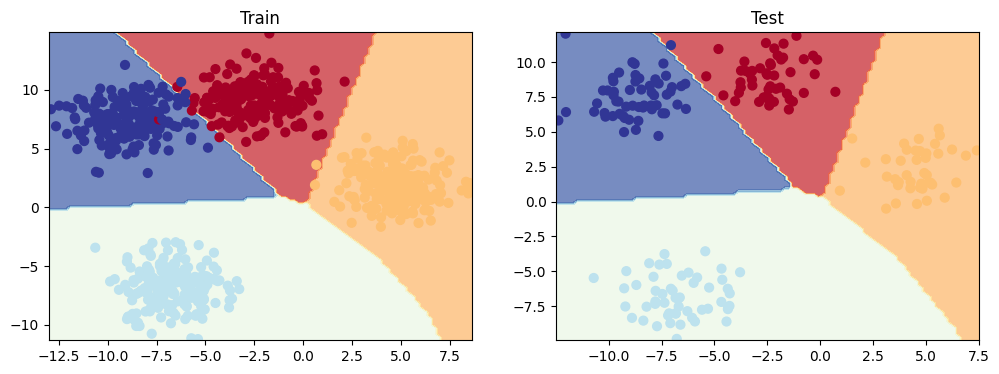

In [75]:
# plot decision boundary on model - show where it's at
plot_model(model_0, "Train")
plot_model(model_0, "Test")

In [76]:
# some more ways to show quality of the model
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.4 MB/s eta 0:00:00


In [81]:
from torchmetrics import Accuracy
torchmetric_ac = Accuracy(task="MULTICLASS",num_classes=CLASSES).to(device)

torchmetric_ac(test_preds, y_blob_test)

tensor(0.9950, device='cuda:0')